In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dir_path = os.path.abspath(os.path.join(os.path.dirname(__file__), "..", ".."))

In [ ]:
def csv_import(name, delimiter="|"):
    x = pd.read_csv(name, encoding='utf8', low_memory=False, delimiter=delimiter,
                    dtype={'Year': int,
                           "total_disbursement": float, 
                           "meta_category": str, 
                           "project_number": str
                           }
                    )
    return x

df= csv_import(dir_path + "/Data/climate_finance_total_with_CRS_disbursement.csv")
df_CRS = pd.read_csv(dir_path + "/Data/CRS_Data/CRS_Data_allyears.csv")

df_CRS= df_CRS[df_CRS['year']>= 2000]
df_CRS['project_phase'] = df_CRS['project_number'].str.extract(r'(7F-\d+\.\d{2})')


C:\Users\chloe\AppData\Local\Temp/ipykernel_61988/3849498717.py:12: DtypeWarning: Columns (6,55,57,60,61,62,79,84,85,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_CRS = pd.read_csv("C:/Users/chloe/Desktop/Master Thesis/Code/ClimateFinanceBERT/Data/CRS_Data/CRS_Data_allyears.csv")


4445


In [ ]:
# common ccodes
common_codes = set(df["project_phase"]) & set(df_CRS["project_phase"])

df_rio = df_CRS[df_CRS["project_phase"].isin(common_codes)].copy()

df_rio = df_rio.merge(
    df[['project_phase', 'meta_category', 'climate_class', 'climate_relevance']],
    on='project_phase',
    how='left'  # Use 'left' to keep all activities in crs_df, even if no match in df
)

print("Original B:", len(df_CRS), "Filtered B:", len(df_rio))
print(df_rio['year'])

Original B: 184022 Filtered B: 43971
0        2006
1        2006
2        2006
3        2008
4        2008
         ... 
43966    2022
43967    2022
43968    2022
43969    2022
43970    2022
Name: year, Length: 43971, dtype: int64


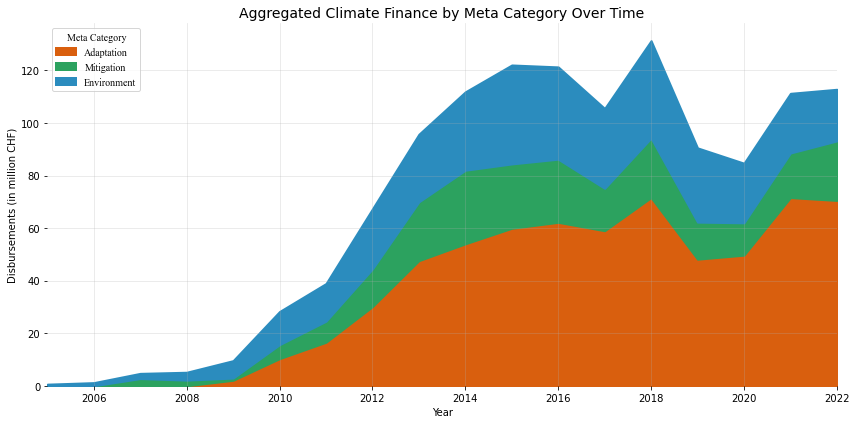

In [5]:
grouped = df_rio.groupby(["year", "meta_category"])["disbursement_national"].sum().unstack().fillna(0)
grouped = grouped.sort_index()
grouped = grouped[["Adaptation", "Mitigation", "Environment"]]

colors = {
    "Adaptation": "#d95f0e",    # Orange
    "Mitigation": "#2ca25f",    # Green
    "Environment": "#2b8cbe"    # Blue
}

fig, ax = plt.subplots(figsize=(12,6))
grouped.plot(
    kind="area",
    stacked=True,
    color=[colors.get(cat, "#ccc") for cat in grouped.columns],
    linewidth=2,
    ax=ax
)

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'

ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
for line in ax.lines:
    line.set_visible(False)
    
plt.title("Aggregated Climate Finance by Meta Category Over Time", fontsize=14)
plt.ylabel("Disbursements (in million CHF)")
plt.xlabel("Year")
plt.xlim(2005, 2022)
plt.xticks(range(2006, 2024, 2))
plt.legend(title="Meta Category")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Figure2a.png", dpi=300, bbox_inches='tight')
plt.show()




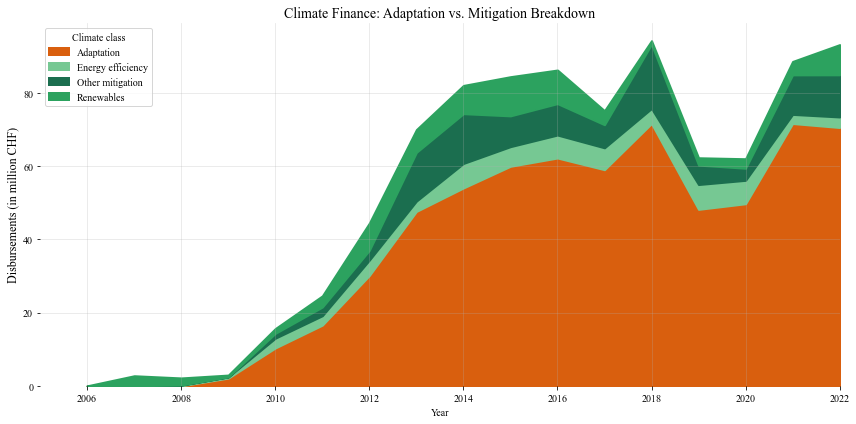

Of the CHF 236.95308899999998 million disbursements classified as mitigation, 30% focus on renewable energy, 25% on energy efficiency, and 44% fall into other mitigation categories.


<Figure size 432x288 with 0 Axes>

In [ ]:
grouped2= df_rio[df_rio['climate_relevance']==1]
grouped2 = grouped2 [grouped2 ["meta_category"] != "Environment"]

renewables = ["Hydro-energy", "Renewables-multiple", "Bioenergy", "Solar-energy"]
efficiency = ["Energy-efficiency"]
other_mit = ["Other-mitigation-projects"]

def map_class(cc):
    if cc == "Adaptation":
        return "Adaptation"
    if cc in renewables:
        return "Renewables"
    if cc in efficiency:
        return "Energy efficiency"
    if cc in other_mit:
        return "Other mitigation"
    return None

grouped2 ["class_bucket"] = grouped2 ["climate_class"].map(map_class)
grouped2 = grouped2.dropna(subset=["class_bucket"])


grouped2 = (
    grouped2.groupby(["year", "class_bucket"])["disbursement_national"]
      .sum()
      .unstack()
      .fillna(0)
      .sort_index()
)


colors2 = {
    "Adaptation": "#d95f0e",
    "Renewables": "#2ca25f",         # base green
    "Energy efficiency": "#76c893",  # lighter green
    "Other mitigation": "#1b6e4f"    # darker green
}

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(grouped2.index) 
grouped2.plot(
    kind="area",
    stacked=True,
    color=[colors2.get(cat, "#ccc") for cat in grouped2.columns],
    linewidth=2,
    ax=ax
)
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
for line in ax.lines:
    line.set_visible(False)

ax.set_title("Climate Finance: Adaptation vs. Mitigation Breakdown", fontsize=14)
ax.set_ylabel("Disbursements (in million CHF)", fontsize=12)
ax.set_xlabel("Year")
ax.legend(title="Climate class")
plt.xlim(2005, 2022)
plt.xticks(range(2006, 2024, 2))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Figure2b.png", dpi=300, bbox_inches='tight')
plt.show()


renewable_pct= (df_rio.disbursement_national[df_rio.climate_class.isin(["Hydro-energy", "Renewables-multiple", "Bioenergy", "Solar-energy"])].sum())/(df_rio.disbursement_national[df_rio.meta_category.isin(['Mitigation'])].sum()) *100
efficiency_pct= (df_rio.disbursement_national[df_rio.climate_class.isin(["Energy-efficiency"])].sum())/(df_rio.disbursement_national[df_rio.meta_category.isin(['Mitigation'])].sum()) *100
mit_pct= (df_rio.disbursement_national[df_rio.climate_class.isin(["Other-mitigation-projects"])].sum())/(df_rio.disbursement_national[df_rio.meta_category.isin(['Mitigation'])].sum()) *100

print(f"Of the CHF {df_rio.disbursement_national[df_rio.meta_category.isin(['Mitigation'])].sum()} million disbursements classified as mitigation, "
      f"{renewable_pct:.0f}% focus on renewable energy, "
      f"{efficiency_pct:.0f}% on energy efficiency, and "
      f"{mit_pct:.0f}% fall into other mitigation categories.")

In [33]:
df_time = df_rio.copy()
df_time['adaptation_funding'] = 0
df_time['mitigation_funding'] = 0
df_time['environment_funding'] = 0
df_time = df_time[(df_time['year'] >= 2006) & (df_time['year'] <= 2022)]

df_time.loc[df_time.meta_category == 'Adaptation', 'adaptation_funding'] = df_time.disbursement_national
df_time.loc[df_time.meta_category == 'Mitigation', 'mitigation_funding'] = df_time.disbursement_national
df_time.loc[df_time.meta_category == 'Environment', 'environment_funding'] = df_time.disbursement_national

df_time = df_time[['year', 'adaptation_funding', 'mitigation_funding', 'environment_funding']]
df_time = df_time.groupby('year').sum().reset_index()

In [ ]:
df_rio = df_rio.rename(columns={'disbursement_national':'CH_Disbursement',
                                        'year':'effective_year'})

df_rio = df_rio[(df_rio['effective_year'] >= 2006) & (df_rio['effective_year'] <= 2022)]


rio_adapt1=df_rio[df_rio.climate_adaptation==1]
rio_adapt1=rio_adapt1[['CH_Disbursement','effective_year']].groupby('effective_year').sum().reset_index()
rio_adapt2=df_rio[df_rio.climate_adaptation==2]
rio_adapt2=rio_adapt2[['CH_Disbursement','effective_year']].groupby('effective_year').sum().reset_index()
rio_miti1=df_rio[df_rio.climate_mitigation==1]
rio_miti1=rio_miti1[['CH_Disbursement','effective_year']].groupby('effective_year').sum().reset_index()
rio_miti2=df_rio[df_rio.climate_mitigation==2]
rio_miti2=rio_miti2[['CH_Disbursement','effective_year']].groupby('effective_year').sum().reset_index()


In [ ]:
# add "0" for missing years in Rio Markers
rio_adapt1=list(rio_adapt1['CH_Disbursement'])
print(len(rio_adapt1))
rio_adapt2=list(rio_adapt2['CH_Disbursement'])
print(len(rio_adapt2))

rio_miti1=list(rio_miti1['CH_Disbursement']) [4:]
print(len(rio_miti1))
rio_miti2=list(rio_miti2['CH_Disbursement'])[4:]
print(len(rio_miti2))

cluster_adap=(df_time['adaptation_funding']).to_list() [4:]
print(len(cluster_adap))
cluster_miti=(df_time['mitigation_funding']).to_list() [4:]
print(len(cluster_miti))


print(cluster_miti)


13
13
13
13
13
13
[5.30795, 8.007623, 14.332552, 22.358031, 27.998382, 24.472723, 24.025915, 16.119672, 22.618578, 14.093874, 12.295622, 16.947798, 22.637468]


In [ ]:
# stackplot function with Rio Markers
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import seaborn as sns
from matplotlib.pyplot import savefig
from matplotlib.patches import Patch

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = (6, 3.6)

years= (range(2010, 2023))



def rio_stacked_area(cluster, rio_principal,rio_significant,output_folder, rio_colors, cluster_color,climate_type,max_y):
    x = list(range(2010,2023))

    
    fig, ax = plt.subplots()
    ax.stackplot(x, [rio_principal,rio_significant],colors= rio_colors, alpha=0.5)
    plt.plot(years,cluster,color=cluster_color,linewidth=6)

    ax.tick_params(labelsize=12)
    ax.set_ylabel('Aggregated aid disbursements (million CHF) \n for Climate Change '+climate_type, labelpad=13, color='#333333',fontsize=12)
    plt.xticks(np.arange(min(x), max(x)+1, 1.0), ['2010','','2012','','2014',
                                                        '','2016','','2018','','2020','','2022',''])
    plt.xlim(2010,2022)
    plt.ylim(0,250)
    

    reversed_colors=list(reversed(list(rio_colors)))
    legend_list = []
    legend_list.append(Patch(facecolor=cluster_color,
                 label='ClimateFinanceBERT'))
    legend_list.append(Patch(facecolor=reversed_colors[0],
                 label='Rio markers significant'))
    legend_list.append(Patch(facecolor=reversed_colors[1],
                 label='Rio markers principal'))


    ax.legend(handles=legend_list,loc="upper left", borderaxespad=0, prop={'size': 9},frameon=True)
    savefig(output_folder, bbox_inches = "tight", dpi=1200)

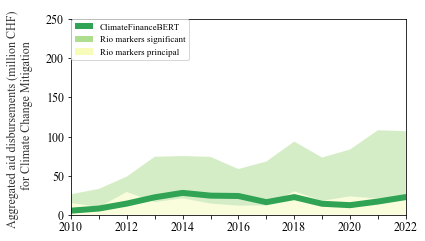

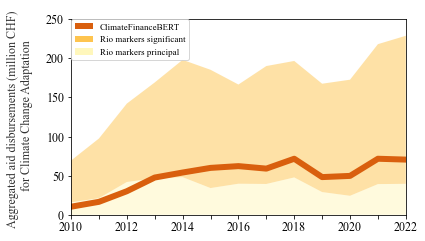

In [ ]:

output_folder_miti="C:/Users/chloe/Desktop/Master Thesis/Code/ClimateFinanceBERT/Code/Plots/Rio_lines_mitigation.png"
output_folder_adap="C:/Users/chloe/Desktop/Master Thesis/Code/ClimateFinanceBERT/Code/Plots/Rio_lines_adaptation.png"
rio_stacked_area(cluster=cluster_miti, rio_principal=rio_miti2,rio_significant=rio_miti1,output_folder=output_folder_miti,
                 rio_colors =['#f7fcb9','#addd8e'], cluster_color='#31a354',climate_type='Mitigation',max_y=23)

rio_stacked_area(cluster=cluster_adap, rio_principal=rio_adapt2,rio_significant=rio_adapt1,output_folder=output_folder_adap,
                 rio_colors =['#fff7bc','#fec44f'], cluster_color='#d95f0e',climate_type='Adaptation',max_y=23)
plt.show()

In [ ]:
# Rio marker values
total_rio_adapt = sum(rio_adapt1) + sum(rio_adapt2)
total_rio_adapt1= sum (rio_adapt1)
total_rio_adapt2= sum (rio_adapt2)
total_rio_miti = sum(rio_miti1) + sum(rio_miti2)
total_rio_miti1= sum(rio_miti1)
total_rio_miti2= sum(rio_miti2)

# cluster values
total_cluster_adapt = sum(cluster_adap)
total_cluster_miti = sum(cluster_miti)

# summary
print(f" Over the period 2010-2022 ODA marked with Rio adaptation markers (Rio marker 1 + 2) was {total_rio_adapt: .2f} million CHF, out of which significant markers represented {total_rio_adapt1:.2f} million CHF and principal markers {total_rio_adapt2:.2f} million CHF. In comparison, the adaptation finance identified by ClimateFinanceBERT was {total_cluster_adapt:.2f} million CHF")
print(f" Over the period 2010-2022 ODA marked with Rio mitigation markers (Rio marker 1 + 2) was {total_rio_miti: .2f} million CHF, out of which significant markers represented {total_rio_miti1:.2f} million CHF and principal markers {total_rio_miti2:.2f} million CHF. In comparison, the adaptation finance identified by ClimateFinanceBERT was {total_cluster_miti:.2f} million CHF")


 Over the period 2010-2022 ODA marked with Rio adaptation markers (Rio marker 1 + 2) was  2200.84 million CHF, out of which significant markers represented 1733.97 million CHF and principal markers 466.88 million CHF. In comparison, the adaptation finance identified by ClimateFinanceBERT was 651.33 million CHF
 Over the period 2010-2022 ODA marked with Rio mitigation markers (Rio marker 1 + 2) was  923.14 million CHF, out of which significant markers represented 679.55 million CHF and principal markers 243.59 million CHF. In comparison, the adaptation finance identified by ClimateFinanceBERT was 231.22 million CHF


In [40]:
df_merged = pd.merge(df_a, df_CRS, on="project_phase", suffixes=("_a", "_b"))

In [72]:
case1 = df[
    (df['climate_relevance'] == 0) &
    ((df['climate_adaptation'] + df['climate_mitigation']) > 1)
]

print
case2 = df[
    (df['climate_relevance'] == 1) &
    ((df['climate_adaptation'] + df['climate_mitigation']) == 0)
]

print("Case 1 (Overcoding) count:", len(case1))
print("Case 2 (Undercoding) count:", len(case2))

case1.to_csv("C:/Users/chloe/Desktop/Master Thesis/Code/ClimateFinanceBERT/Data/overcoding.csv", index=False)
case2.to_csv("C:/Users/chloe/Desktop/Master Thesis/Code/ClimateFinanceBERT/Data/undercoding.csv", index=False)

Case 1 (Overcoding) count: 483
Case 2 (Undercoding) count: 65


In [ ]:
columns_main = ['projectno', 'title', 'text', 'meta_category', 'climate_class']
columns_rio = ['climate_adaptation', 'climate_mitigation']

examples_case1 = case1[columns_main + columns_rio].sample(5, random_state=42)
case2= case2[(case2['meta_category'] != "Environment")]
examples_case2 = case2[columns_main + columns_rio].sample(5, random_state=42)

examples_case1['case'] = 'Overcoding'
examples_case2['case'] = 'Undercoding'


examples_all = pd.concat([examples_case1, examples_case2], axis=0).reset_index(drop=True)

pd.set_option('display.max_colwidth', None) 
def truncate_text(text, n=30):
    words = text.split()
    return ' '.join(words[:n]) + ' [...]' if len(words) > n else text


examples_all['text'] = examples_all['text'].apply(truncate_text)


# Optional: for display in notebook with bold separation
from IPython.display import display
def highlight_separation(s):
    return ['border-left: 3px solid black' if s.name in columns_rio else '' for _ in s]

display(examples_all.style.apply(highlight_separation, axis=1))

,projectno,title,text,meta_category,climate_class,climate_adaptation,climate_mitigation,case
0,7F10076,Scaling Up Youth Employment in Agriculture Initiative,scaling up youth employment in agriculture initiative education systems in southern africa do not prepare youth for work they cannot access or create economic opportunities and ignore the available options [...],nan,nan,24.000000,12.000000,Overcoding
1,7F10919,Strengthening Social Protection in Zambia,strengthening social protection in zambia switzerland aims to increase the resilience of poor and vulnerable households in zambia by strengthening the governments systems for managing and delivering social assistance to [...],nan,nan,21.000000,0.000000,Overcoding
2,7F07324,UNOPS. Livelihood & food Trust Fund,unops livelihood food trust fund,nan,nan,3.000000,3.000000,Overcoding
3,7F10508,Support to Relief and Recovery from COVID-19,support to relief and recovery from covid the proposed interventions support the government of nepal in its efforts to contain the further spread of covid and to address the socioeconomic [...],nan,nan,4.000000,4.000000,Overcoding
4,7F08480,Regional and Local Economic Development in the East West Corridor (RLED-EWEC),regional and local economic development in the east west corridor rledewec the regional local economic development east west corridor project rledewec has been implemented since by the mekong institute an [...],nan,nan,12.000000,0.000000,Overcoding
5,7F09540,Reducing the risks of natural disasters in the South-East Department of Haiti (RRC / South-East),reducing the risks of natural disasters in the southeast department of haiti rrc southeast in a context of recurring quotnaturalquot disasters that undermine the countrys recovery efforts the project aims [...],Adaptation,Adaptation,0.000000,0.000000,Undercoding
6,7F08739,Managing the risk of natural hazards through capacity building and increased cooperation,managing the risk of natural hazards through capacity building and increased cooperation working to reduce the risk of natural disasters is a fundamental element of improving the security of local [...],Adaptation,Adaptation,0.000000,0.000000,Undercoding
7,7F08757,Mekong Region Land Governance (MRLG),mekong region land governance mrlg the swiss agency for development and cooperation sdc has been supporting the mekong region land governance mrlg project in cambodia lao pdr myanmar and vietnam [...],Mitigation,Hydro-energy,0.000000,0.000000,Undercoding
8,7F10251,Peru. Regional Hub Lima. Participation from Latin America - Carribean in Global DRR Platform - Geneva - May 13-17. 2019,peru regional hub lima participation from latin america carribean in global drr platform geneva may from may to will be held in geneva the vi session of the global platform [...],Adaptation,Adaptation,0.000000,0.000000,Undercoding
9,7F09223,Multi-Donor civil society support program in Rwanda,multidonor civil society support program in rwanda the program aims at strengthening the capacity of rwanda civil society to engage constructively with the government on policy planning and monitoring issues [...],Mitigation,Solar-energy,0.000000,0.000000,Undercoding
